In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#Calling Required Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

#data visualization
import seaborn as sns

#Data imputation
from sklearn.impute import SimpleImputer

#Label encoder to convert to dummy variables
from sklearn.preprocessing import LabelEncoder

# 1.2 Processing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder as ohe
from sklearn.preprocessing import StandardScaler as ss
from sklearn.compose import ColumnTransformer as ct
from sklearn.decomposition import PCA

#To Balance the classes we use SMOTE Library
from imblearn.over_sampling import SMOTE, ADASYN

#Calling Libraries To Build various Models
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier


#For ROC graphs & metrics
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

#Bayesoptimization
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
#Reading the dataset for training the model and validating it.
train=pd.read_csv("../input/train.csv")

#Reading the final Test dataset on which the predictions are done
test=pd.read_csv("../input/test.csv")
train.shape
test.shape

(23856, 142)

In [3]:
train.dtypes #to check the data types
train.columns.values #to check the column names

#To check the categorical variables
[col for col, dt in train.dtypes.items() if dt=='object']#or below
list(set(train.columns) - set(train._get_numeric_data().columns))

['edjefa', 'Id', 'dependency', 'edjefe', 'idhogar']

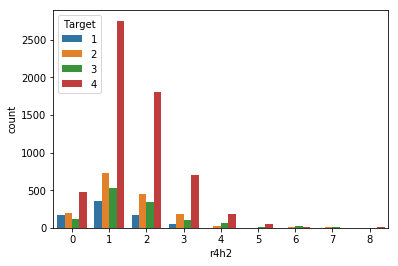

In [4]:
#Males 12 years of age and older
sns.countplot("r4h2",        # Variable whose distribution is of interest
              hue= "Target",    # Distribution will be gender-wise
              data = train)

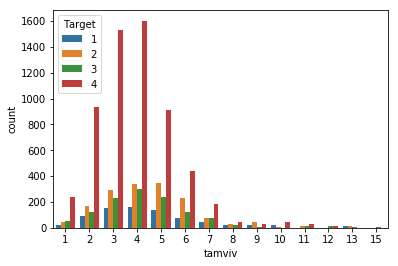

In [5]:
#number of persons living in the household
sns.countplot("tamviv",        # Variable whose distribution is of interest
              hue= "Target",    # Distribution will be gender-wise
              data = train)

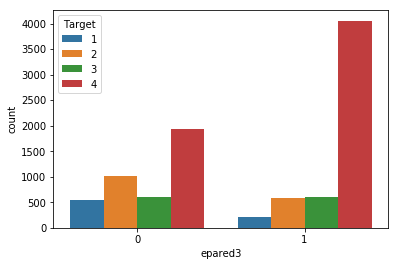

In [6]:
#if walls are good
sns.countplot("epared3",        # Variable whose distribution is of interest
              hue= "Target",    # Distribution will be gender-wise
              data = train)

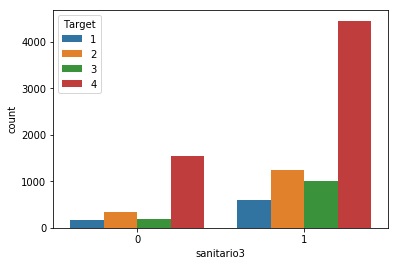

In [7]:
#toilet connected to  septic tank
sns.countplot("sanitario3",        # Variable whose distribution is of interest
              hue= "Target",    # Distribution will be gender-wise
              data = train)

<BarContainer object of 2973 artists>

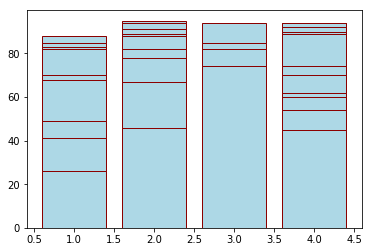

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

#age of the household heads
familyHead=train[train.parentesco1==1]
ax.bar(familyHead["Target"],
       familyHead["age"],             # x-values or bar-locations
                     # height of bars
       color = "lightblue",       # inner-bar color (optional)
       edgecolor="darkred"        # optional
       )  

In [9]:
#To find out which column have the null values in it
train.isnull().sum()#to find the number of records with null values in each column
train.isna().any()[lambda x: x]#to find the columns which have atleast one null value.
train.columns[train.isnull().any()].tolist()#list of columns with atleast one null value.

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [10]:
meanimp=SimpleImputer(strategy="mean")
modeimp=SimpleImputer(strategy="most_frequent")

#DATA IMPUTATION FOR TRAIN DATASET
train['v2a1'] = meanimp.fit_transform(train[['v2a1']])
train['v18q1'] = modeimp.fit_transform(train[['v18q1']])
train['rez_esc'] = modeimp.fit_transform(train[['rez_esc']])
train['meaneduc'] = meanimp.fit_transform(train[['meaneduc']])
train['SQBmeaned'] = meanimp.fit_transform(train[['SQBmeaned']])

#DATA IMPUTATION FOR TEST DATASET
test['v2a1'] = meanimp.fit_transform(test[['v2a1']])
test['v18q1'] = modeimp.fit_transform(test[['v18q1']])
test['rez_esc'] = modeimp.fit_transform(test[['rez_esc']])
test['meaneduc'] = meanimp.fit_transform(test[['meaneduc']])
test['SQBmeaned'] = meanimp.fit_transform(test[['SQBmeaned']])

In [11]:
#COVERTING CATEGORICAL TO NUMERICAL IN TRAIN DATASET
train['dependency']=train['dependency'].replace({'yes': 1, 'no': 0}).astype(np.float32)
train['edjefe']=train['edjefe'].replace({'yes': 1, 'no': 0}).astype(np.float32)
train['edjefa']=train['edjefa'].replace({'yes': 1, 'no': 0}).astype(np.float32)

#COVERTING CATEGORICAL TO NUMERICAL IN TEST DATASET
test['dependency']=test['dependency'].replace({'yes': 1, 'no': 0}).astype(np.float32)
test['edjefe']=test['edjefe'].replace({'yes': 1, 'no': 0}).astype(np.float32)
test['edjefa']=test['edjefa'].replace({'yes': 1, 'no': 0}).astype(np.float32)


In [12]:
test.shape#(23856, 142)
train.shape#(9557, 143)

(9557, 143)

In [13]:
#To drop the unnecessary columns(unique columns) in Train and Test datasets
train.drop(columns=['Id','idhogar'],inplace=True)#(23856, 140)
test.drop(columns=['Id','idhogar'],inplace=True)#(9557, 141)

In [14]:
test.shape#(23856, 140)
train.shape#(9557, 141)

(9557, 141)

In [15]:
#Seperating the target variable from predicting variables. 
X = train.iloc[:,0:140]
y = train.iloc[:,140]
X.shape
y.shape

(9557,)

In [16]:
"""PCA PROCESSING"""
#using standard scaler standardize the modified train data
scale = ss()
X = scale.fit_transform(X)
#Applying the above logic for test data set also
finalTest=scale.fit_transform(test)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
#Check the shape of the data after applying PCA.
X.shape
finalTest.shape

(23856, 140)

In [18]:
#Splitting the trained dataset to build the models

X_train, X_test, y_train, y_test =   train_test_split(X,y,test_size = 0.3, stratify = y)
X_train.shape
X_test.shape

(2868, 140)

In [19]:
#Building Random forest model
#  RandomForest modeling
from sklearn.ensemble import RandomForestClassifier as rf
#Instantiate RandomForest classifier
randForModel = rf(n_estimators=50)
randForModel = randForModel.fit(X_train, y_train)
rfmodel = randForModel.predict(X_test)
# ChecK accuracy
(rfmodel == y_test).sum()/y_test.size   

0.9013249651324965

In [20]:
#Applying Bayesian search approach to tune the model further

bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    rf(
       n_jobs = 2         # No need to tune this parameter value
      ),

    # 2.12 Specify estimator parameters that you would like to change/tune
    {
        'n_estimators': (50, 200),           # Specify integer-values parameters like this
        'criterion': ['gini', 'entropy'],     # Specify categorical parameters as here
        'max_depth': (4, 50),                # integer valued parameter
        'max_features' : (10,64),             # integer-valued parameter
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   # Float-valued parameter
    },

    # 2.13
    n_iter=20,            # How many points to sample
    cv = 3                # Number of cross-validation folds
)
  
bayes_cv_tuner.fit(X_train, y_train)
#To get the best parameter set after bayesian optimization
bayes_cv_tuner.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 64,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200}

In [21]:
#Building the random forest model using the best params.
modelrfTuned=rf(criterion="entropy",
               max_depth=21,
               max_features=64,
               min_weight_fraction_leaf=0.0,
               n_estimators=205)
    
modelrfTuned = modelrfTuned.fit(X_train, y_train)
rfTunedModel=modelrfTuned.predict(X_test)
(rfTunedModel == y_test).sum()/y_test.size 

0.9281729428172942

In [22]:
# Modeling with KNN 
modelKNN = KNeighborsClassifier(n_neighbors=1)
modelKNN1 = modelKNN.fit(X_train, y_train)
knnModel = modelKNN1.predict(X_test)
(knnModel == y_test).sum()/y_test.size 

0.8277545327754533

In [23]:
#Predicting Test dataset with the tuned rf model
rfTunedTestdata=modelrfTuned.predict(finalTest)

In [24]:
#Applying Bayesian search approach to tune the model further
bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    KNeighborsClassifier(
       n_neighbors=4         # No need to tune this parameter value
      ),
    {"metric": ["euclidean", "cityblock"]},
    n_iter=32,            # How many points to sample
    cv = 2            # Number of cross-validation folds
   )
bayes_cv_tuner.fit(X_train, y_train)
bayes_cv_tuner.best_params_

/opt/conda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/skopt/optimizer/optimize

{'metric': 'cityblock'}

In [25]:
 #fitting the data for the tuned model
modelKNN = KNeighborsClassifier(n_neighbors=1,metric= 'cityblock')
modelKNN1 = modelKNN.fit(X_train, y_train)
#predicting the X_test with tuned model of KNN
knnTunedMdl = modelKNN1.predict(X_test)
(knnTunedMdl == y_test).sum()/y_test.size 

0.8887726638772664

In [26]:
#Predicting Test dataset with the tuned rf model
knnTunedTestdata=modelKNN1.predict(finalTest)

In [27]:
#3 Modeling using XGB Classifier
xgbModel=XGBClassifier()
modelXGB=xgbModel.fit(X_train, y_train)
xgbModel = modelXGB.predict(X_test)
(xgbModel == y_test).sum()/y_test.size 

0.7276847977684798

In [28]:
#Applying Bayesian search approach to tune the model further
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    

    cv = 2,
    n_jobs = 3,
    n_iter = 10,   
    verbose = 0,
    refit = True,
    random_state = 42
)
bayes_cv_tuner.fit(X_train, y_train)
bayes_cv_tuner.best_params_

{'colsample_bylevel': 0.8015579071911014,
 'colsample_bytree': 0.44364889457651413,
 'gamma': 3.811128976537413e-05,
 'learning_rate': 0.2700390206185342,
 'max_delta_step': 18,
 'max_depth': 36,
 'min_child_weight': 2,
 'n_estimators': 83,
 'reg_alpha': 1.5057560255472018e-06,
 'reg_lambda': 0.08186810622382998,
 'scale_pos_weight': 0.029004593634154585,
 'subsample': 0.8835665823899177}

In [29]:
#predicting the X_test with tuned model of XGB.
xgbTunedModel = bayes_cv_tuner.predict(X_test)
(xgbTunedModel == y_test).sum()/y_test.size 

0.9246861924686193

In [30]:
#Predicting Test dataset with the tuned xgb model
xgbTunedTestdata=bayes_cv_tuner.predict(finalTest)

In [31]:

#LIGHT GBM CLASSIFIER
import lightgbm as lgb
modelLGBM= lgb.LGBMClassifier()
LGBMModel=modelLGBM.fit(X_train, y_train)
lbgModel=LGBMModel.predict(X_test)
(lbgModel == y_test).sum()/y_test.size 

0.8629707112970711

In [32]:
#Applying Bayesian search approach to tune the model further
bayes_cv_tuner = BayesSearchCV(
    #  Place your estimator here with those parameter values
    #      that you DO NOT WANT TO TUNE
    lgb.LGBMClassifier(
       n_jobs = 2         # No need to tune this parameter value
      ),

    # 2.12 Specify estimator parameters that you would like to change/tune
    {
        'n_estimators': (50, 100),           # Specify integer-values parameters like this
        'criterion': ['gini', 'entropy'],     # Specify categorical parameters as here
        'max_depth': (4, 50),                # integer valued parameter
        'max_features' : (10,64),             # integer-valued parameter
        'min_weight_fraction_leaf' : (0,0.5, 'uniform')   # Float-valued parameter
    },

    # 2.13
    n_iter=32,            # How many points to sample
    cv = 3                # Number of cross-validation folds
)
    
bayes_cv_tuner.fit(X_train, y_train) 
#To get the best parameter set after bayesian optimization
bayes_cv_tuner.best_params_
   

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 63,
 'min_weight_fraction_leaf': 0.03336444948783574,
 'n_estimators': 96}

In [33]:
#predicting the X_test with tuned model of LGB.
lgbTunedModel=bayes_cv_tuner.predict(X_test)
(lgbTunedModel == y_test).sum()/y_test.size 

0.8615760111576011

In [34]:
#Predicting Test dataset with the tuned LBGM model
lgbmTunedTestdata=bayes_cv_tuner.predict(test)

In [35]:
#FINAL MODEL FROM ALL THE DERIVED TUNED MODELS
#Concatenating all the predicted results and form as a dataframe
dictOfMdls = {'rfTunedModel': rfTunedModel,'xgbTunedModel':xgbTunedModel,'knnTunedMdl':knnTunedMdl, 'lgbTunedModel': lgbTunedModel}
tundedDF=pd.DataFrame(data=dictOfMdls)
tundedDF.shape
rfmdl=rf(n_estimators=50)
rfFinalMdl=rfmdl.fit(tundedDF, y_test)

In [36]:
#Concatenating all the predicted results of final Test data and form as a dataframe
dictOfTestMdls = {'rfTunedModel': rfTunedTestdata,'xgbTunedModel':xgbTunedTestdata,'knnTunedMdl':knnTunedTestdata, 'lgbTunedModel': lgbmTunedTestdata}
tundedTestDF=pd.DataFrame(data=dictOfTestMdls)

#Predicting the resultant column for the above using the model created from tuned models of train data.
finalTestDataPrdict=rfFinalMdl.predict(tundedTestDF)

In [37]:
testDataset=pd.read_csv("../input/test.csv")
#Saving the csv file in local with id and target column for final test dataset.
ResultDF=pd.DataFrame(data={'Id':testDataset['Id'],'Target':finalTestDataPrdict})
ResultDF.to_csv('result.csv')